# Mapping the Latent Space of CXR Patient Geometry
## Zebrastack V0 VAE trained on the CovidNet chest radiograph dataset
The zebrastack is a variational auto-encoder that is _very_ roughly aligned with the distributed hierarchical architecture + shifter circuit.  Here it is applied to recognition of the CovidNet chest radiograph dataset.

First we load some center-surround processed images

In [6]:
import numpy as np
from common.image_preprocessing import data_all, data_temp, temp_from_original
from pathlib import Path, PurePath
import time

sz = 128
temp_relative_path = PurePath(f"{sz}x{sz}") / 'clahe_processed'
cxr8_original_path = data_all / 'chest-nihcc' / 'by_class' / 'no_finding'
cxr8_temp = temp_from_original(cxr8_original_path, temp_relative_path)
processed_imgs = {}

start_time = time.time()
for npy_filepath in cxr8_temp.glob('*.npy'):
    img = np.load(npy_filepath)
    img = np.reshape(img, (img.shape[0],img.shape[1],1))
    processed_imgs[npy_filepath.stem] = img
    if len(processed_imgs) % 100 == 0:
        print(npy_filepath.stem, img.shape, end='\r')
end_time = time.time()

print(f"Loaded {len(processed_imgs)} npy in {end_time - start_time} seconds")

Loaded 60361 npy in 132.18855619430542 seconds


Partition the data in to train and test: 90% train and 10% test.  We are assuming all images are from distinct patients, so there is no need to partition by subject.

In [8]:
test_count = int(len(processed_imgs)/10)
processed_img_list = list(processed_imgs.values())
x_test = processed_img_list[:test_count]
x_train = processed_img_list[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(f"Training data has shape {x_train.shape}")
print(f"Testing data has shape {x_test.shape}")

Training data has shape (54325, 128, 128, 1)
Testing data has shape (6036, 128, 128, 1)


## Defining the Variational Autoencoder
To defined the variational autoencoder, we need to helper functions:
* A function for reparameterized sampling
* A function for KLDiv loss

In [11]:
from cxr_projection.zebrastack_v0_model import create_autoencoder
encoder, decoder, autoencoder = create_autoencoder()

Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

## Pre-Training the model
Train by calling .fit with the training data.  
* Batch size of 512 helps convergence, but causes resource exhaustion > 128x128.
* Epochs > 1024 take a while, but tend to lead to better results

In [12]:
autoencoder.fit(x_train[:5000], x_train[:5000], 
                epochs=128, batch_size=128, 
                shuffle=True, validation_data=(x_test[:500], x_test[:500]))

Train on 5000 samples, validate on 500 samples
Epoch 1/128
5000/5000 [==============================] - 20s 4ms/step - loss: 1112.8608 - val_loss: 1039.7815
Epoch 2/128
5000/5000 [==============================] - 6s 1ms/step - loss: 887.0689 - val_loss: 974.2058
Epoch 3/128
5000/5000 [==============================] - 6s 1ms/step - loss: 749.7710 - val_loss: 716.6831
Epoch 4/128
5000/5000 [==============================] - 6s 1ms/step - loss: 702.5579 - val_loss: 778.1645
Epoch 5/128
5000/5000 [==============================] - 6s 1ms/step - loss: 675.3168 - val_loss: 807.7455
Epoch 6/128
5000/5000 [==============================] - 6s 1ms/step - loss: 662.8702 - val_loss: 665.3349
Epoch 7/128
5000/5000 [==============================] - 6s 1ms/step - loss: 655.3296 - val_loss: 671.8916
Epoch 8/128
5000/5000 [==============================] - 6s 1ms/step - loss: 649.9284 - val_loss: 811.5264
Epoch 9/128
5000/5000 [==============================] - 6s 1ms/step - loss: 644.6692 - val_lo

## Inspecting Reconstructing Images
To qualitatively assess the model, look at a few images and their reconstructions from latent vectors

In [13]:
from functools import lru_cache
import numpy as np

# @lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

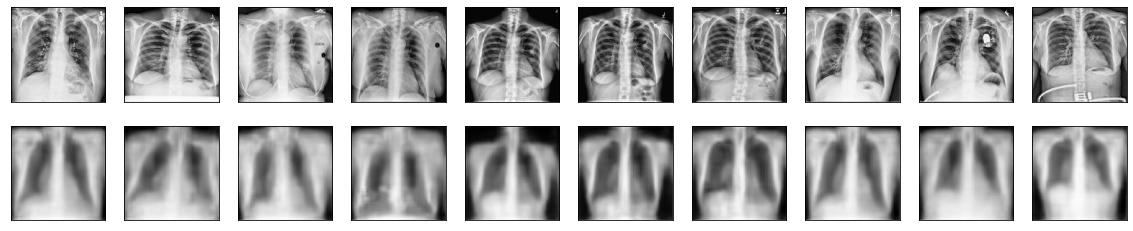

In [44]:
from cxr_projection.show_original_decoded import show_grayscale, show_original_decoded

encode_only_imgs = encoder.predict(x_test[:10])
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

OK? so then save the model

In [45]:
from datetime import datetime
from common.image_preprocessing import data_all, data_temp

weights_cxr8_temp = temp_from_original(cxr8_original_path, PurePath(f"{sz}x{sz}") / 'weights')
timestamp = datetime.now().strftime("%Y%m%d%H%M")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_encoder.h5")
encoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_encoder.h5")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_decoder.h5")
decoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_decoder.h5")
print("Saving ", weights_cxr8_temp / f"{timestamp}_rgc_autoencoder.h5")
autoencoder.save_weights(weights_cxr8_temp / f"{timestamp}_rgc_autoencoder.h5")

Saving  E:\Data\zebtrastack_temp\chest-nihcc\128x128\weights\202009031540_rgc_encoder.h5
Saving  E:\Data\zebtrastack_temp\chest-nihcc\128x128\weights\202009031540_rgc_decoder.h5
Saving  E:\Data\zebtrastack_temp\chest-nihcc\128x128\weights\202009031540_rgc_autoencoder.h5


In [ ]:
shift_processed_path = "E:\\Data\\anat0mixer_temp\\shifter_processed"
for n in range(len(x_train_shifted)):
    np.save(shift_processed_path+f"\\x_train_shifted_{n}", 
            x_train_shifted[n])

In [ ]:
for n in range(len(x_test_shifted)):    
    np.save(shift_processed_path+f"\\x_test_shifted_{n}", 
            x_test_shifted[n])

In [ ]:
from pathlib import Path
x_train_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_train_shifted_*.npy')
x_train_shifted = []
for fn in x_train_fns:
    x_train_shifted.append(np.load(fn))

x_test_fns = \
    Path('E:\\Data\\anat0mixer_temp\\shifter_processed') \
        .glob('x_test_shifted_*.npy')
x_test_shifted = []
for fn in x_test_fns:
    x_test_shifted.append(np.load(fn))

In [ ]:
x_train_shifted = np.array(x_train_shifted)
x_test_shifted = np.array(x_test_shifted)
x_train_shifted.shape, x_test_shifted.shape

In [ ]:
autoencoder.fit(x_train_shifted, x_train_shifted, 
                epochs=256, batch_size=128, 
                shuffle=True, validation_data=(x_test_shifted, x_test_shifted))

In [ ]:
import tensorflow as tf
autoencoder.save_weights('E:\\Data\\anat0mixer_temp\\autoencoder_v1')
encoder.save_weights('E:\\Data\\anat0mixer_temp\\encoder_v1')
decoder.save_weights('E:\\Data\\anat0mixer_temp\\decoder_v1')

In [ ]:
encoded_shift = encoder.predict(x_test_shifted[80:90])
decoded_imgs_shift = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encoded_shift[2]]
show_original_decoded(x_test_shifted[80:90], decoded_imgs_shift, sz)

## Saving the Model
If the model output looks good, then save it for subsequent use

In [ ]:
encoder.save('data\zebrastack_v0_covidnet_encoder_model')
decoder.save('data\zebrastack_v0_covidnet_decoder_model')

## Anat0Mixer Interaction

In [ ]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = decoded_pixel_array.reshape(sz,sz)
    # interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=0)
    # interp_array = interp_array.reshape(sz*4, sz*4)
    # ax.imshow(interp_array, cmap='gray')
    # a=im.get_array()    
    im.set_array(interp_array)
    fig.canvas.draw()
    return kwargs['1']

In [ ]:
%matplotlib notebook
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}

for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

decoded_pixel_array = decode_latent(decoder, tuple([slider.value for slider in kwargs.values()]))
interp_array = decoded_pixel_array.reshape(sz,sz)


In [ ]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
im = ax.imshow(interp_array, cmap='gray')

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'

import gc
gc.disable()
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)

In [ ]:
gc.enable()